In [168]:
import pandas as pd
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [247]:
# MIGHT HAVE TO CHANGE COLUMN NAMES - NOT SURE IF I HAVE THE CORRECT AMOUNT

def read_data(filename):

    df = pd.read_csv(filename, low_memory=False, header=None)
    df.columns = ["Timestamp", "LineID", "Direction", "JourneyPatternID", "TimeFrame",
                  "VehicleJourneyID", "Operator", "Congestion", "Lon", "Lat",
                  "Delay", "BlockID", "VehicleID", "StopID", "AtStop"]
    
    return df

In [248]:
# ADDING HOUR, DAY, HUMANTIME COLUMNS
# DROPPING IRRELEVANT COLUMNS
# CAN REMAIN UNCHANGED - MIGHT WANT TO MAKE HOUR MORE GRANULAR? 

def add_features(df):

    # Add column for human readable time
    df['HumanTime'] = pd.to_datetime(df['Timestamp'], unit='us')


    # Add day of week column
    df['Day'] = df['HumanTime'].dt.dayofweek

    # Add hour of day column
    df['Hour'] = df['HumanTime'].dt.hour


    # Dropping irrelevant columns
    for column in ['BlockID', 'Direction', 'Operator', 'Delay', 'Congestion']:
        df = df.drop(column, 1)
    
    return df

In [223]:
# REMOVE ALL JOURNEYS WHERE BUS DOESN'T START AT CORRECT STOP HERE
# FIND MOST COMMON STARTING STOP, DROP ALL JOURNEYS WHICH DON'T HAVE THIS
# AS THEIR FIRST STOP

def filter_direction(df):

    # converting data, adding compound feature
    for column in ['TimeFrame', 'VehicleJourneyID',]:
            df[column] = df[column].astype('str')

    df["JourneyGroup"] = df["TimeFrame"] + df["VehicleJourneyID"]


    patterns = df.JourneyPatternID.unique()

    tempdf = pd.DataFrame()

    for pattern in patterns:
        patterndf = df[df.JourneyPatternID == pattern]

        firstlines = patterndf.groupby(["TimeFrame", "VehicleJourneyID"]).head(1)
        start = firstlines.StopID.mode()[0]
        #     print(start)

        # Getting all journeys that start at the right stop
        valid_journeys = []
        for index, row in firstlines.iterrows():
            if row.StopID == start:
                valid_journeys.append(row.JourneyGroup)

        # removing journeys that don't start at the right stop
        patterndf = patterndf[patterndf.JourneyGroup.isin(valid_journeys)]


        if tempdf.empty:
            tempdf = patterndf

        else: 
            tempdf = pd.concat([tempdf, patterndf], axis=0)

    return tempdf

In [224]:
# DROPPING ROWS WHERE BUS ISN'T AT STOP 
# THIS SECTION NEEDS TO BE CHANGED, INCLUDE ONLY ROWS WHERE STOPID CHANGES

def drop_rows(df):

    # drop duplicate rows
    df = df.drop_duplicates(["TimeFrame", "VehicleJourneyID", "StopID"])

    # mean = df.JourneyGroup.value_counts().mean()
    # drop trips with less than 5 stops
    df = df[df.groupby('JourneyGroup').JourneyGroup.transform(len) > 5]
    
    return df

In [225]:
def runtime_function(row, mydict):
    # Takes a row and a dictionary of start times
    # returns time elapsed (seconds) between that row's timestamp and the start of the line
    start = mydict[row.TimeFrame, row.VehicleJourneyID]["time"]
    current = row.Timestamp
    return (current - start) // 1000000

In [240]:
# ADDING RUNTIME COLUMN - THIS CAN REMAIN UNCHANGED

def add_runtime(df):
    # Putting the first sightings of a vehiclejourneyid and timeframe combo timestamp into a dictionary
    start_times = {}

    # This gives you the first line anything has been seen by
    firstlines = df.groupby(["TimeFrame", "VehicleID", "VehicleJourneyID"]).head(1)

    # This iterates through them and assigns values to the dictionary
    for index, row in firstlines.iterrows():
        start_times[row.TimeFrame, row.VehicleJourneyID] = {"time":row.Timestamp, "loc":[row.Lat, row.Lon]}


    df['Runtime'] = ""

    # Applies this function to the newdf
    df['Runtime'] = df.apply(lambda row: runtime_function(row, start_times),axis=1)
    
    return df

In [227]:
def insert_into_file(df, writefile):
    """  This function writes a dataframe (df) to a file (writefile),
        or does nothing if the file doesn't exist
        
        CHANGED FROM OTHER
    """
    try:
        with open(writefile, 'a') as f:
#             df.to_csv(f, header=False, index=False)
            print(writefile, "exists")
            pass
    except IOError:
        with open(writefile, 'w+') as f:
            df.to_csv(f, header=False, index=False)


In [245]:
def main(read_directory, write_directory):
    for read_file in os.listdir(read_directory):
        if read_file.endswith(".csv"):
            if os.path.isfile(write_directory + "/" + read_file):
                print(read_file, "exists")
            else:
                print("Reading", read_file, "from", read_directory)
                try:
                    df = read_data(read_directory + "/" + read_file)
                    df = add_features(df)
                    df = filter_direction(df)
                    df = drop_rows(df)
                    df = add_runtime(df)

                    with open(write_directory + "/" + read_file, 'w+') as f:
                        df.to_csv(f, header=False, index=False)
                except (ValueError, IndexError) as error:
                    print(error, "!")
                    print("Couldn't finish", read_file)
                    

                print("Finished", read_file)
                print()
    print("Finished main!")

In [246]:
read_directory = "bus_data/line_data2"
write_directory = "bus_data/clean_data2"

main(read_directory, write_directory)

1.csv exists
102.csv exists
104.csv exists
11.csv exists
111.csv exists
114.csv exists
116.csv exists
118.csv exists
120.csv exists
122.csv exists
123.csv exists
13.csv exists
130.csv exists
14.csv exists
140.csv exists
142.csv exists
145.csv exists
14C.csv exists
15.csv exists
150.csv exists
151.csv exists
15A.csv exists
15B.csv exists
16.csv exists
161.csv exists
16C.csv exists
17.csv exists
17A.csv exists
18.csv exists
184.csv exists
185.csv exists
220.csv exists
236.csv exists
238.csv exists
239.csv exists
25.csv exists
25A.csv exists
25B.csv exists
25X.csv exists
26.csv exists
27.csv exists
270.csv exists
27A.csv exists
27B.csv exists
27X.csv exists
29A.csv exists
31.csv exists
31A.csv exists
31B.csv exists
32.csv exists
32A.csv exists
32B.csv exists
32X.csv exists
33.csv exists
33A.csv exists
33B.csv exists
33X.csv exists
37.csv exists
38.csv exists
38A.csv exists
38B.csv exists
39.csv exists
39A.csv exists
4.csv exists
40.csv exists
40B.csv exists
40D.csv exists
41.csv exists
41

In [229]:
readfile = "bus_data/line_data2/15.csv"

df = read_data(readfile)
df = add_features(df)
df = filter_direction(df)
df = drop_rows(df)
df = add_runtime(df)

In [230]:
df.tail()

,Timestamp,LineID,JourneyPatternID,TimeFrame,VehicleJourneyID,Lon,Lat,VehicleID,StopID,AtStop,HumanTime,Day,Hour,JourneyGroup,Runtime
2564395,1359632636000000,15,1001,2013-01-31,7271,-6.263947,53.333710,33020,1074,1,2013-01-31 11:43:56,3,11,2013-01-317271,2322
2564410,1359632653000000,15,1001,2013-01-31,5002,-6.213551,53.378284,33248,1196,0,2013-01-31 11:44:13,3,11,2013-01-315002,4156
2564418,1359632669000000,15,1001,2013-01-31,7264,-6.218322,53.375755,33488,4382,0,2013-01-31 11:44:29,3,11,2013-01-317264,3412
2564423,1359632669000000,15,1001,2013-01-31,7289,-6.285324,53.309166,33546,1163,0,2013-01-31 11:44:29,3,11,2013-01-317289,1158
2564430,1359632669000000,15,1001,2013-01-31,7278,-6.271373,53.315929,33018,1167,1,2013-01-31 11:44:29,3,11,2013-01-317278,1781


In [231]:
journey = df[df.JourneyGroup == "2013-01-315002"]
times = journey[['Runtime']]


,Runtime
2560467,0
2560892,418
2560975,500
2561046,578
2561074,760
2561082,762
2561116,782
2561135,801
2561246,922
2561403,1081


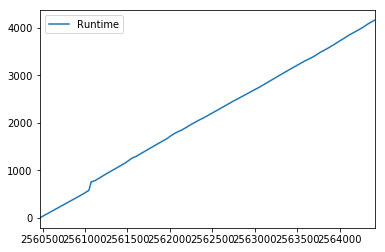

In [220]:
times.plot()

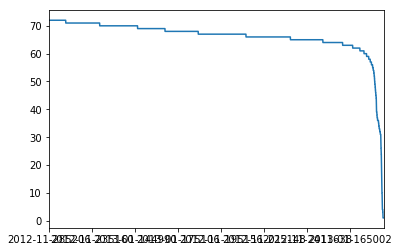

In [148]:
df.JourneyGroup.value_counts().plot()

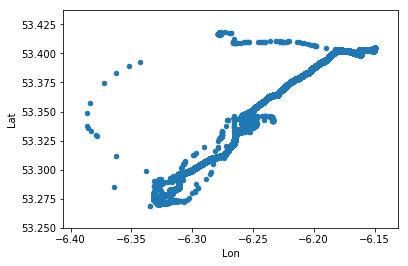

In [149]:
locations = newdf[["Lon", "Lat"]]
locations.plot.scatter(x="Lon", y="Lat")

In [108]:
newdf.JourneyGroup.unique()

array(['2012-11-065891', '2012-11-065899', '2012-11-065902', ...,
       '2013-01-317271', '2013-01-317278', '2013-01-317289'], dtype=object)

In [109]:
xxxx = df[df.JourneyGroup == "2013-01-085057"]
xxxx.shape

(71, 14)

In [ ]:
firstlines = patterndf.groupby(["TimeFrame", "VehicleJourneyID"]).head(1)



In [ ]:
# ADDING RUNTIME COLUMN - THIS CAN REMAIN UNCHANGED

# # Putting the first sightings of a vehiclejourneyid and timeframe combo timestamp into a dictionary
# start_times = {}

# # This gives you the first line anything has been seen by
# firstlines = df.groupby(["TimeFrame", "VehicleJourneyID"]).head(1)

# # This iterates through them and assigns values to the dictionary
# for index, row in firstlines.iterrows():
#     start_times[row.TimeFrame, row.VehicleJourneyID] = {"time":row.Timestamp, "loc":[row.Lat, row.Lon]}


# df['Runtime'] = ""

# # Applies this function to the newdf
# df['Runtime'] = df.apply(lambda row: add_runtime(row, start_times),axis=1)